# Decision Trees

In dit notebook vind je 3 opdrachten.
- <a href="#dt_opdracht1"> Opdracht 1 </a> maak je ter voorbereiding van het college.
- <a href="#dt_opdracht2"> Opdracht 2 </a> is optioneel, dit gaat je zeker helpen om decision trees beter te begrijpen, maar is voor dit college niet essentieel. (Het helpt je wel bij DEP, waar je zelf een decision tree gaat implementeren.)
- <a href="#dt_opdracht3"> Opdracht 3 </a> maken we in het college.

<a id ="dt_opdracht1"></a>
## Opdracht 1

We gaan aan de slag met data over woningen in New York  en San Francisco. Is op basis van de kenmerken van een woning te bepalen of deze in New York of San Francisco ligt?

We zullen eerst een voorbeeld geven - bestudeer deze goed. Daarna moet je zelf een decision tree trainen.

In [279]:
from random import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Classificeer de huizen in onderstaande data set met een decision tree. In de kolom `in_sf` staat een 1 als het huis in San Fransisco staat en een 0 als het huis in New York staat.

In [280]:
homes = pd.read_csv('decision_trees_homes_ny_sf.csv', sep=",")
print(f"{len(homes)} meetwaarden, waarvan {homes.in_sf.sum()} in San Fransisco")
homes.head()

492 meetwaarden, waarvan 268 in San Fransisco


,in_sf,beds,bath,price,year_built,sqft,price_per_sqft,elevation
0,0,2.0,1.0,999000,1960,1000,999,10
1,0,2.0,2.0,2750000,2006,1418,1939,0
2,0,2.0,2.0,1350000,1900,2150,628,9
3,0,1.0,1.0,629000,1903,500,1258,9
4,0,0.0,1.0,439000,1930,500,878,10


Een voorbeeld van een simpele beslisboom wordt hieronder gegeven.

1. Kies het modeltype

In [281]:
model = DecisionTreeClassifier()

2. Kies de features en targetvariabele

In [282]:
feat_names = ['beds', 'bath']
cat_names = ['San Francisco', 'New York']
feats = np.array(homes[feat_names])
cat = homes['in_sf']

3. Maak een train- en testset

In [283]:
feats_train, feats_test, cat_train, cat_test = train_test_split(feats, cat, random_state=10)
print("{} elementen in de trainset en {} elementen in de testset".format(len(cat_train), len(feats_test)))

369 elementen in de trainset en 123 elementen in de testset


4. Train het model

In [284]:
model.fit(feats_train, cat_train)

DecisionTreeClassifier()

5. Evalueer de resultaten

In [285]:
# M.b.v. de score wordt de accuracy berekend: het percentage voorspellingen dat correct
model.score(feats_test, cat_test)

0.7723577235772358

In [286]:
# Alternatieve manier om de voorspellende waarde te berekenen is door het model de klasse te voorspellen voor
# de testset van de features en deze te vergelijken met de testset van de klassen.
cat_model = model.predict(feats_test)
accuracy_score(cat_test, cat_model)

0.7723577235772358

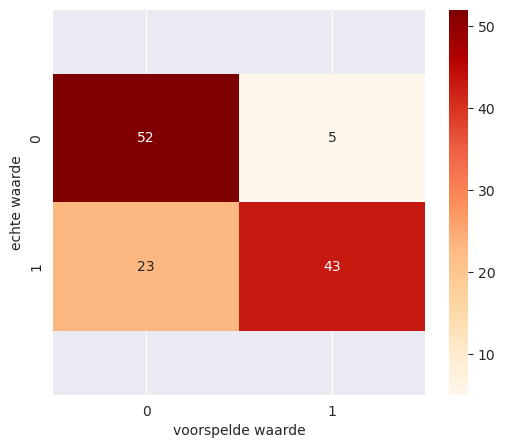

In [287]:
# Het is ook interessant om te kijken welke voorspellingen goed gaan en welke niet gaan. 
# Je ziet dat vooral de NY-huizen niet goed voorspeld worden. Dus het is zaak om onderscheidende features toe te voegen.

import seaborn as sns 
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(cat_test, cat_model)

# Maak van de array een pandas dataframe om te visualiseren
df_cm = pd.DataFrame(cm)

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

ax = sns.heatmap(df_cm, annot=True, cmap='OrRd')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xlabel('voorspelde waarde')
ax.set_ylabel('echte waarde')

plt.show()

Visualisatie van de decision tree met GraphViz.

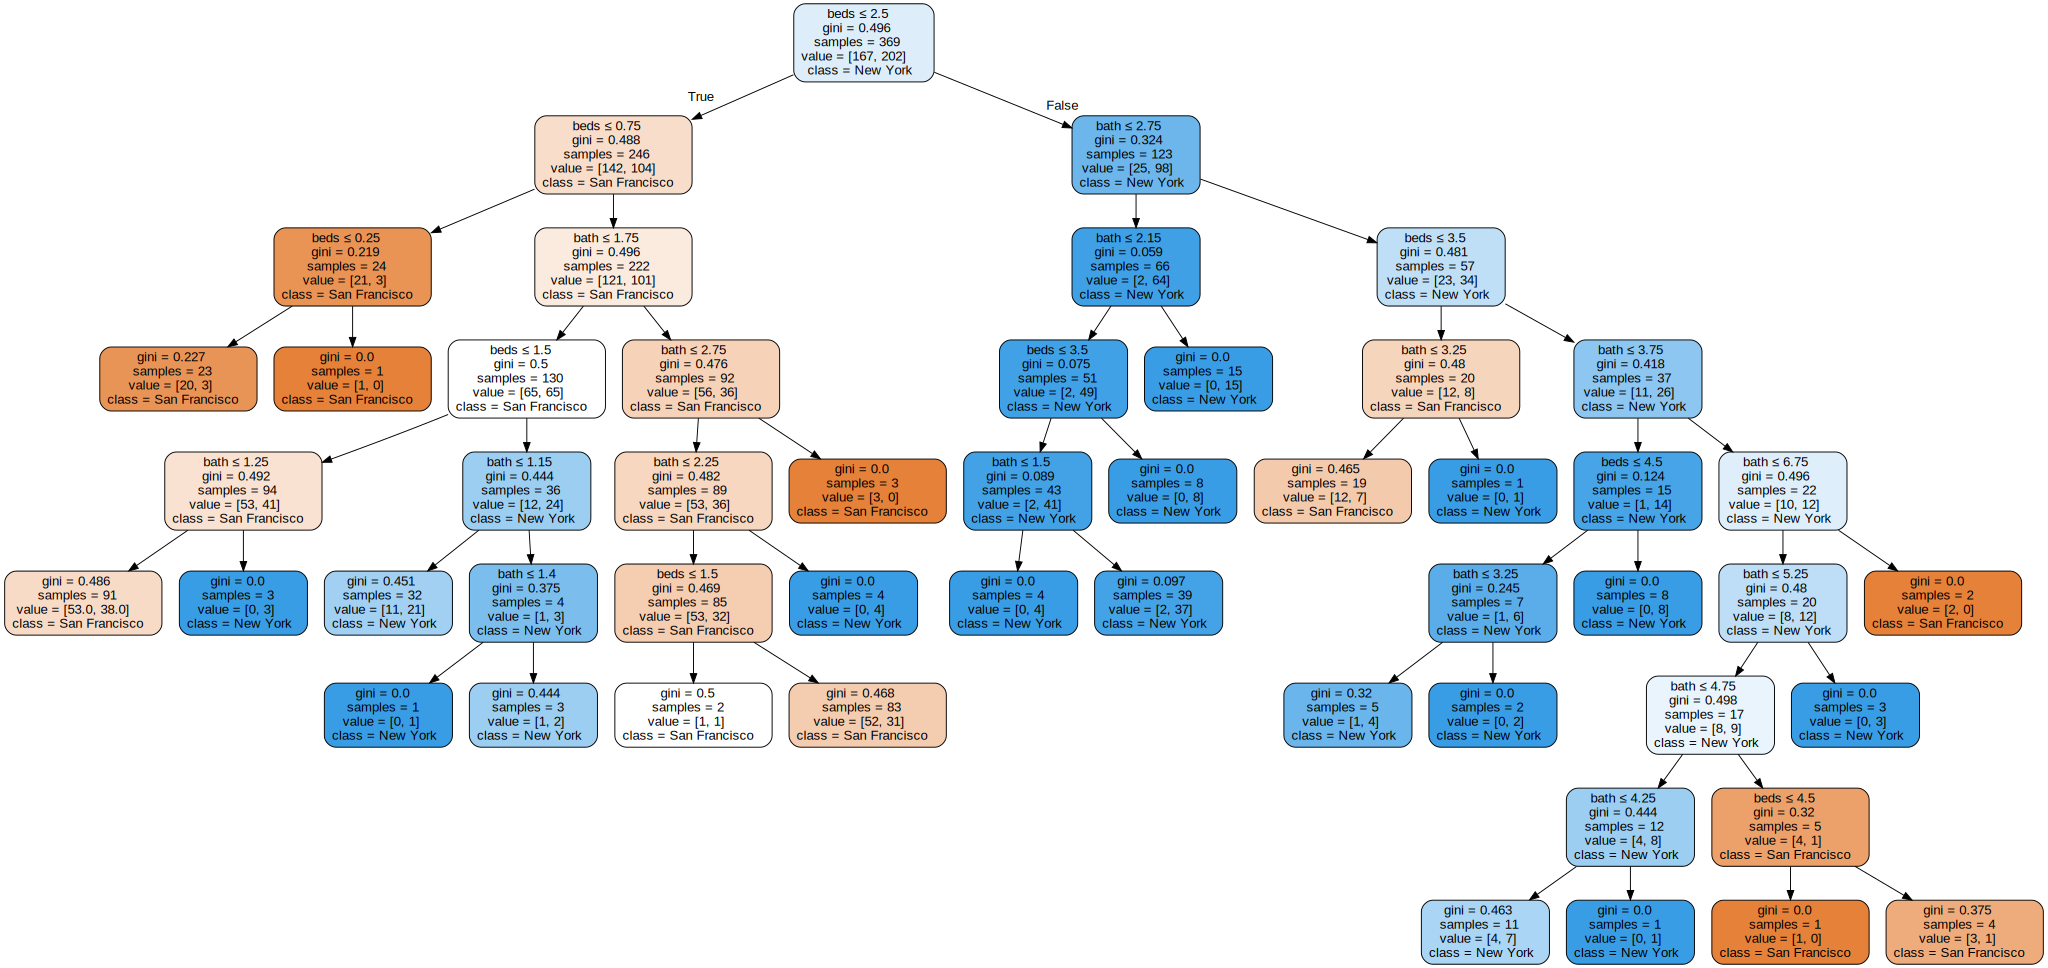

In [288]:
data = export_graphviz(model, out_file=None, feature_names=feat_names, class_names=cat_names,   
                         filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(data)
graph

Maak nu zelf een betere beslisboom. Het is dus de bedoeling om een hogere accuracy te krijgen! 

Denk aan het toevoegen van features, aanpassen van hyperparameters, etc.

Selecteer de _features_ en de target _classes_.

In [289]:
df = pd.read_csv("decision_trees_homes_ny_sf.csv", sep=",")
f_names = ["beds", "bath", "price", "year_built", "sqft", "price_per_sqft", "elevation"]
t_names = ["San Francisco", "New York"]
features = df[f_names]
target = df["in_sf"]

Opdelen in een train- en een testset.

In [290]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=10)

Maak een _decision tree_ model, train deze en bereken de voorspellende waarde.

In [291]:
model = DecisionTreeClassifier(max_depth=6)
model.fit(features_train, target_train) 

DecisionTreeClassifier(max_depth=6)

Visualisatie van de decision tree met GraphViz.

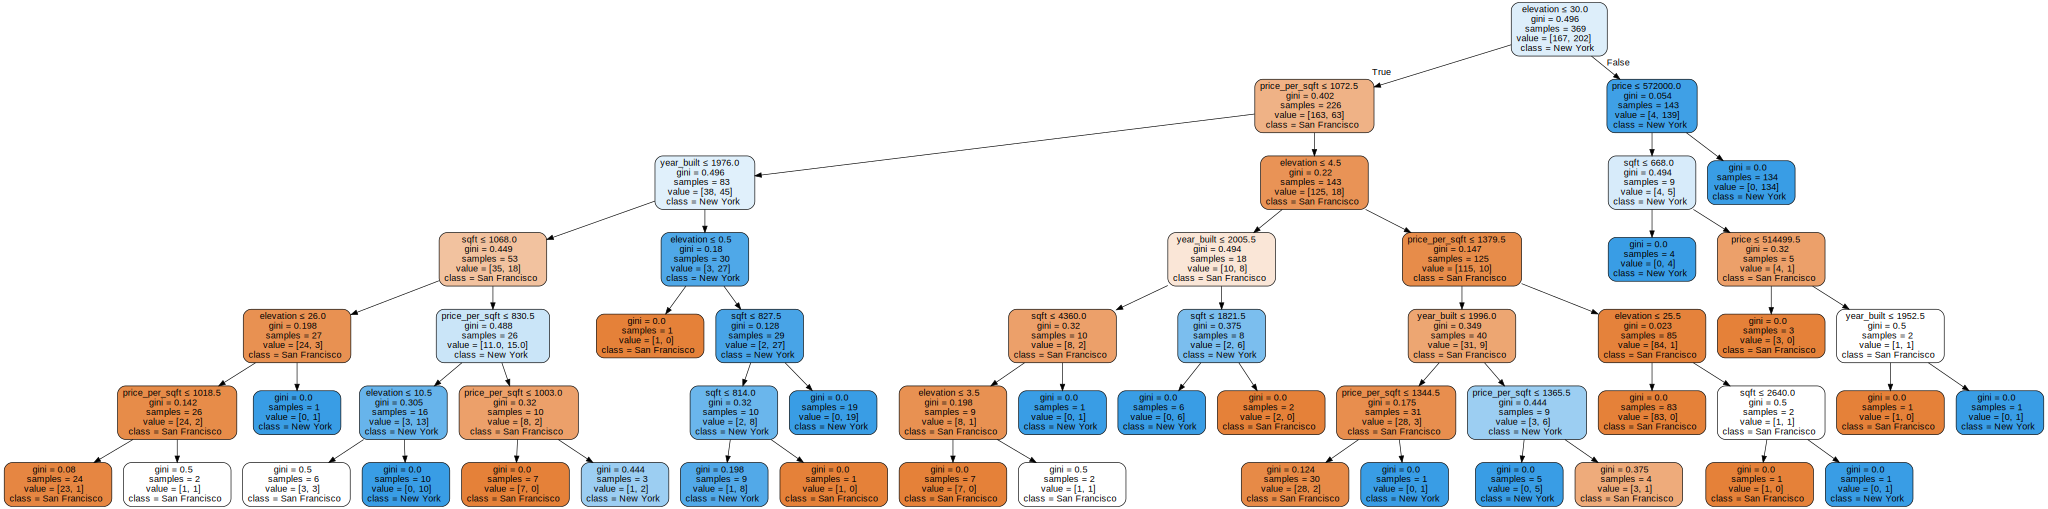

In [292]:
data = export_graphviz(
    model,
    out_file=None,
    feature_names=f_names,
    class_names=t_names,
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(data)
graph

Bepaal de invloed van het aantal lagen van de boom op de voorspellingsscore.

In [293]:
model.score(features_test, target_test)

0.9024390243902439

<a id = "dt_opdracht2"></a>
## Opdracht 2

In dit notebook wordt het onderliggende zelflerende algoritme van decision trees uitgelegd. Dit is gebaseerd op entropie. Je kunt in dit notebook zelf spelen met de werking van entropie om zo een beter gevoel te krijgen voor de werking van decision trees.

In [294]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import scipy.stats as st

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [295]:
weer = pd.DataFrame({'weertype': ['slecht', 'slecht', 'slecht', 'medium', 'mooi', 'medium', 'mooi'],
                     'weerklasse': [0, 0, 0, 1, 2, 1, 2],
                     'temperatuur': [3, 18, 32, 36, 19, 7, -10], 
                     'regen': [True, True, True, False, False, False, False]})

Entropie $E(S)$:

$$E(S) = -\sum_{i=1}^{c}p_{i}\log_{2}(p_{i})$$

Als er twee klassen zijn (dus $c = 2$ mogelijke waarden voor doelvariabele $S$), dan ligt de waarde van de entropie tussen de 0 (alles behoort tot één klasse) en 1 (meetwaarden zijn precies verdeeld over de twee klassen).

NB. Als je het aandeel $p_1$ van de eerste klasse $c_1$ weet, dan weet je ook het aandeel $p_2 = 1 - p_1$ van de tweede klasse $c_2$. Bij méér dan twee klassen gaat dit natuurlijk niet meer op.

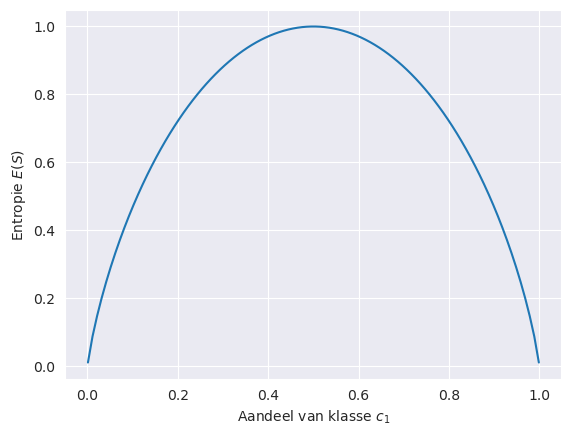

In [296]:
fig, ax = plt.subplots(1, dpi=100)

x = np.linspace(.001,.999,100)
y = -x * np.log2(x) + -(1-x) * np.log2(1-x)
ax.set_xlabel(r"Aandeel van klasse $c_1$")
ax.set_ylabel(r"Entropie $E(S)$")

plt.plot(x,y)
plt.show()


Bepaal met bovenstaande formule de entropie van doelvariabele `weertype`.

In [297]:
weer

,weertype,weerklasse,temperatuur,regen
0,slecht,0,3,True
1,slecht,0,18,True
2,slecht,0,32,True
3,medium,1,36,False
4,mooi,2,19,False
5,medium,1,7,False
6,mooi,2,-10,False


In [298]:
# Entropie voor weertype [slecht, medium, mooi]
# Berekening 1
E_weertype = - ((3/7) * np.log2(3/7) + (2/7) * np.log2(2/7) + (2/7) * np.log2(2/7))
E_weertype

1.5566567074628228

In [299]:
# Berekening 2
st.entropy([3,2,2], base=2)

1.556656707462823

In [300]:
# Berekening 3
st.entropy(weer.groupby('weertype').count()['weerklasse'], base=2)

1.556656707462823

### Split 1. Regen of temperatuur?

Bereken de entropie en information gain bij een split op `regen`.

In [312]:
weer

,weertype,weerklasse,temperatuur,regen
0,slecht,0,3,True
1,slecht,0,18,True
2,slecht,0,32,True
3,medium,1,36,False
4,mooi,2,19,False
5,medium,1,7,False
6,mooi,2,-10,False


In [301]:
weather_rain_true = weer[weer["regen"] == True]
weather_rain_false = weer[weer["regen"] == False]

In [302]:
entropy_weather_type = -((3/7 * np.log2(3/7)) + (2/7 * np.log2(2/7)) + (2/7 * np.log2(2/7)))

entropy_rain_true = -(1 / 1 * np.log2(1 / 1))
entropy_rain_false = -((2/4 * np.log2(2/4)) + (2/4 * np.log2(2/4)))

information_gain_rain = entropy_weather_type - ((3/7 * entropy_rain_true) + (4/7 * entropy_rain_false)) 

In [303]:
information_gain_rain

0.9852281360342514

We kunnen ook splitten op `temperatuur` op veel verschillende manieren. Bereken alleen de entropie en de information gain bij een split op `temperatuur` bij 20 graden.

In [313]:
weer

,weertype,weerklasse,temperatuur,regen
0,slecht,0,3,True
1,slecht,0,18,True
2,slecht,0,32,True
3,medium,1,36,False
4,mooi,2,19,False
5,medium,1,7,False
6,mooi,2,-10,False


In [304]:
weather_temperature_above = weer[weer["temperatuur"] > 20]
weather_temperature_below = weer[weer["temperatuur"] <= 20]

In [305]:
entropy_weather_type = -((3/7 * np.log2(3/7)) + (2/7 * np.log2(2/7)) + (2/7 * np.log2(2/7)))

entropy_temperature_above = -((1/2 * np.log2(1/2)) + (1/2 * np.log2(1/2)))
entropy_temperature_below = -((2/5 * np.log2(2/5)) + (2/5 * np.log2(2/5)) + (1/5 * np.log2(1/5)))

information_gain_temperature = entropy_weather_type - ((2/7 * entropy_temperature_above) + (5/7 * entropy_temperature_below))

In [306]:
information_gain_temperature

0.18385092540042125

Welke split is het beste?

### Split 2. Welke temperatuur?

Bereken ná een split op `regen` (dus als tweede laag) de entropie bij een split op `temperatuur` met de scheiding bij $t = 0$, $t = 10$ en $t = 20$ graden.

Welke split is het beste?

In [315]:
t = 0

In [316]:
weather_rain_true

,weertype,weerklasse,temperatuur,regen
0,slecht,0,3,True
1,slecht,0,18,True
2,slecht,0,32,True


In [317]:
weather_rain_low_above = weather_rain_true[weather_rain_true["temperatuur"] > t]
weather_rain_low_below = weather_rain_true[weather_rain_true["temperatuur"] <= t]

In [ ]:
entropy_rain_true = 

### Decision Tree

Maak de decision tree met `DecisionTreeClassifier`. Kies als parameter `criterion='entropy'`.

Visualisatie van de decision tree met GraphViz.

<a id="dt_opdracht3"></a>
## Opdracht 3 - German Credit Data

Voor deze oefening kijken we naar de data set 'german'. Deze data set bevat gegevens van een Duitse bank over mensen die een lening aanvragen. De vraag is of de bank ze deze lening wil verstrekken. Dat doet de bank alleen als er een grote kans is dat mensen de lening kunnen terugbetalen. Wij gaan hiervoor een beslisboom algoritme bouwen.

#### Initialisatie
In de cell hieronder zetten we alle statements die packages inladen netjes bij elkaar. In de loop van het college zullen we hier nog een en ander aan toe moeten voegen.

In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

### Data understanding
We gaan nu kijken naar de data set 'german.data'. De data staat op Canvas. Daar staat ook het data dictionary van de data set: hierin wordt uitgelegd wat de betekenis is van alle attributen.

Lees de data set in, bekijk de data set en krijg een eerste gevoel bij deze data. Zorg dat je in ieder geval de volgende zaken helder hebt:
- Wat zijn de meetniveau's van alle attributen?
- Zijn er attributen met *rare* waardes?

In [308]:
german = pd.read_csv('german.data', sep = ' ', quotechar = "'")

In [309]:
pd.set_option('display.max_columns', None)
german.head()

,Euros op rekening,Duur Lening,Leengeschiedenis,Doel vd Lening,Bedrag Lening,Bedrag op spaarrekening,Duur huidige baan,lening als perc van inkomen,persoonlijke status,overige schuldeisers,huidige woning sinds,eigendom,leeftijd,andere leningen,huisvesting,aantal leningen,baan,verantwoordelijk voor,telefoon,buitenlandse werknemer,lening terugbetaald
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67.0,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22.0,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49.0,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45.0,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53.0,A143,A153,2,A173,2,A191,A201,2


Maak nu een boxplot van de leeftijd. Merk op dat standaard toepassen van plt.boxplot niet lukt als gevolg van de missende waarden in de data. Hoe kunnen we nu wel zo'n boxplot krijgen?

Trek ook conclusies over eventuele uitschieters en of we *iets* moeten doen met die uitschieters.

We gaan straks proberen een beslisboom te maken die voorspeld aan wie de bank zonder veel risico een lening kan verstrekken op basis van deze data. Probeer de target feature te vinden en maak een staafdiagram ('bar chart') voor deze feature. In dit staafdiagram moet je duidelijk kunnen aflezen hoe vaak de target feature welke waarde aanneemt. 

### Data preparation
We gaan de dataset nu klaarstomen voor een decision tree met behulp van een aantal opschoningsacties.

Niet alleen de waardes van een attribuut kunnen *rotzooi* bevatten, ook de attribuutnamen ofwel kolomnamen. Als er spaties in de kolomnaam staan, dan kun je niet meer gebruik maken van de dot-notatie van pandas. Kijk bijvoorbeeld maar eens naar het attribuut *leeftijd*. Bij opdracht 2. heb je waarschijnlijk al gemerkt dat de kolomnaam eigenlijk 'leeftijd ' is met een extra spatie die daar op een of andere manier ingekomen is. Waarschijnlijk bij het exporteren van een Excelsheet naar een CSV bestand... 

Anyway, dit spatie moet weg! Je kunt bijvoorbeeld niet de kolom leeftijd selecteren door german.leeftijd. Wat wel altijd werkt is het selecteren van kolommen door middel van de brackets [], bijvoorbeeld german['leeftijd ']. Maar stel dat we nu gewoon de kolomnaam van leeftijd willen hernoemen en de spatie weghalen, hoe kunnen we dit doen?


De laatste stap voordat we kunnen gaan modelleren is het selecteren van de juiste features. Ten eerste moeten we ons afvragen of het **ethisch verantwoord** om het attribuut te gebruiken. Maak een selectie van de attributen die wel geschikt zijn en licht toe waarom je bepaalde attributen niet geschikt vindt.


Ten tweede moeten we kijken naar het meetniveau van de attributen: niet alle meetniveau's zijn geschikt voor een beslisboom. Het Decision Tree algoritme van sci-kit learn kan alleen kwantitatieve features aan als input en kan ook niet omgaan met missende waarden. Een mogelijke oplossing is om de rijen met missende waarden weg te laten en de kwalitatieve features om te zetten met behulp van get_dummies.

Merk op: hoewel deze oplossing niet optimaal is voor wat betreft de performance, zullen we hier nu voor kiezen. Alternatieven zijn om de beslisboom te maken in R (waar wel een standaardimplementatie is die overweg kan met categoriale features en missings) of te kiezen voor een ander python package. Voor dit laatste zijn er verschillende mogelijkheden onder andere: CatBoost, LightGBM, of H2O, maar elk ook weer met hun eigen nadelen. Zo kan CatBoost bijvoorbeeld  alleen symmetrische decision trees leren en is de visualisatie van een boom niet begrijpelijk. 

### Modelling
De dataset is klaar voor het decision tree algoritme.

Doorloop de bekende stappen om tot een beslisboom komen. Bepaal de kwaliteit van de beslisboom met de juiste metrics. Pas de hyperparameters aan om tot een zo hoog mogelijke score te komen.

Beargumenteer of de hoogst gevonden accuracy *goed* is of niet.

Visualiseer tenslotte deze beslisboom. Is deze in de praktijk te gebruiken in een oplossing / applicatie? En is deze uit te leggen aan de *business* of klant?